# 패키지

In [1]:
# 패키기 불러오기
import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings(action='ignore')

In [2]:
# 구글 코랩을 통해서 GPU를 이용한 학습을 함

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [3]:
# 재현가능성을 위한 seed 고정
def seed_everything(seed = 22):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)

  # torch 용
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything()

In [4]:
BATCH_SIZE = 128
EPOCHS = 10

# 데이터 가져오기

## 이미지

In [5]:
import pickle

DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

image_dict = {}

# load
for i in range(5):
  with open(DATA_DIR + f'image_data_dict_v2_{i + 1}.pickle', 'rb') as f:
      image = pickle.load(f)
      
  image_dict.update(image)

len(image_dict)

22458

## 게임 메타 정보

In [6]:
content_df = pd.read_csv('/content/drive/MyDrive/재테크/Steam/Data/steam_image_meta_data_clean_result.csv')
content_df.head()

,game_id,title,content,Image_url,genres,clean_genres,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags,label_encode_game_id
0,768520,Red Solstice 2: Survivors,Sequel to the best-seller ​The Red Solstice​. ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tStrategy RPG\t\t...,"['Strategy RPG', 'Real Time Tactics', 'Charact...",768520,Red Solstice 2: Survivors,Ironward,505 Games,NaN,879,324,0,"100,000 .. 200,000",1543,1543,1844,1844,2699.0,2999.0,10.0,"English, Simplified Chinese, German, French, R...","RPG, Strategy",1880,"{'Strategy RPG': 211, 'Real Time Tactics': 200...",15392
1,251570,7 Days to Die,7 Days to Die is an open-world game that is a ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tEarly Access\t\t...,"['Early Access', 'Survival', 'Voxel', 'Zombies...",251570,7 Days to Die,The Fun Pimps,The Fun Pimps Entertainment LLC,NaN,150334,22536,0,"5,000,000 .. 10,000,000",6655,629,1821,299,749.0,2499.0,70.0,"English, French, German, Spanish - Spain, Ital...","Action, Adventure, Indie, RPG, Simulation, Str...",19008,"{'Early Access': 5923, 'Survival': 5384, 'Voxe...",2415
2,671510,DESOLATE,DESOLATE is a first person horror survival exp...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tSurvival\t\t\t\t...,"['Survival', 'Horror', 'Open World', 'Zombies'...",671510,DESOLATE,Nearga,HypeTrain Digital,NaN,4358,1953,0,"200,000 .. 500,000",235,74,213,74,999.0,2499.0,60.0,"English, Russian, French, German, Spanish - Sp...","Action, Adventure, RPG",109,"{'Survival': 260, 'Horror': 232, 'Open World':...",13585
3,613590,Dungeon Of Zaar - Open Beta,Dungeon of Zaar is a competitive tactical game...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tStrategy\t\t\t\t...,"['Strategy', 'Indie', 'Free to Play', 'Early A...",613590,Dungeon Of Zaar - Open Beta,KURB,Plug In Digital,NaN,87,37,0,"20,000 .. 50,000",0,0,0,0,0.0,0.0,0.0,"English, French","Free to Play, Indie, Strategy, Early Access",1,"{'Strategy': 37, 'Indie': 35, 'Free to Play': ...",12513
4,374280,Hired Ops,Hired Ops is a session-based online shooter de...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"['FPS', 'Multiplayer', 'Action', 'Free to Play...",374280,Hired Ops,Absolut Soft LLC,Joccish,NaN,5270,3193,0,"100,000 .. 200,000",281,19,142,19,0.0,0.0,0.0,"English, Russian, Simplified Chinese","Action, Free to Play, Massively Multiplayer",524,"{'FPS': 156, 'Multiplayer': 120, 'Action': 112...",6269


In [7]:
num_classes = content_df['label_encode_game_id'].max() + 1

# 데이터 셋 만들기

In [8]:
from PIL import Image

labels = []
images = []

def get_labels_images(x):
  game_id = x['game_id']
  label = x['label_encode_game_id']
  image = image_dict[game_id]
  image = Image.fromarray(image)
  image = image.resize((32, 32)).convert('RGB')
  image = np.array(image)
  image = image.reshape(1, 32, 32, 3)
  image = np.swapaxes(image, 1, 3)

  labels.append(label)
  images.append(image)

_ =  content_df.apply(lambda x : get_labels_images(x), axis = 1)
labels = np.array(labels)
images = np.concatenate(images) / 255

In [9]:
labels.shape

(22528,)

In [10]:
images.shape

(22528, 3, 32, 32)

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data.reshape(-1,1)

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.y_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.LongTensor(self.y_data[idx])[0]
      return x, y

In [12]:
dataset = CustomDataset(x_data = images, y_data = labels)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

for (X_train, y_train) in dataloader:
  print(X_train.size())
  print(y_train.size())
  break

torch.Size([128, 3, 32, 32])
torch.Size([128])


# ResNet 50

In [13]:
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes,
                           kernel_size = 3,
                           stride = stride,
                           padding = 1,
                           bias = False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes,
                           kernel_size = 3,
                           stride = 1,
                           padding = 1,
                           bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes,
                           kernel_size = 3,
                           stride = stride,
                           padding = 1,
                           bias = False),
          nn.BatchNorm2d(planes))
      
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_planes = 16
    
    self.conv1 = nn.Conv2d(3, 16,
                           kernel_size = 3,
                           stride = 1,
                           padding = 1,
                           bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(block, 32, num_blocks[0], stride = 1)
    self.layer2 = self._make_layer(block, 64, num_blocks[1], stride = 2)
    self.layer3 = self._make_layer(block, 128, num_blocks[2], stride = 2)
    self.layer4 = self._make_layer(block, 256, num_blocks[3], stride = 2)
    self.linear = nn.Linear(256, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)

    return out

In [14]:
model = ResNet(block = BasicBlock, num_blocks = [2, 2, 2, 2], num_classes = num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, eps = 1e-06, patience = 10)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

## 학습

In [15]:
def train(model, train_loader, optimizer):
  model.train()
  train_loss = 0
  correct = 0

  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [16]:
dataset = CustomDataset(x_data = images, y_data = labels)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, dataloader, optimizer)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} % \n")

[EPOCH: 1], 	Train Loss: 10.1263, 	Train Accuracy: 0.00 % 

[EPOCH: 2], 	Train Loss: 9.9587, 	Train Accuracy: 0.00 % 

[EPOCH: 3], 	Train Loss: 9.8541, 	Train Accuracy: 0.00 % 

[EPOCH: 4], 	Train Loss: 9.6876, 	Train Accuracy: 0.02 % 

[EPOCH: 5], 	Train Loss: 9.5200, 	Train Accuracy: 0.00 % 

[EPOCH: 6], 	Train Loss: 9.3835, 	Train Accuracy: 0.02 % 

[EPOCH: 7], 	Train Loss: 9.2319, 	Train Accuracy: 0.03 % 

[EPOCH: 8], 	Train Loss: 9.1924, 	Train Accuracy: 0.05 % 

[EPOCH: 9], 	Train Loss: 8.9960, 	Train Accuracy: 0.08 % 

[EPOCH: 10], 	Train Loss: 8.8746, 	Train Accuracy: 0.03 % 



In [17]:
dataset = CustomDataset(x_data = images, y_data = labels)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

model.eval()
preds = []
for batch_idx, (image, _) in enumerate(dataloader):
  image = image.to(DEVICE)
  output = model(image)
  preds.append(output.cpu().detach().numpy())

preds = np.concatenate(preds)

In [18]:
preds.shape

(22528, 22443)

In [19]:
preds_T = preds.T

In [20]:
preds_T.shape

(22443, 22528)

In [21]:
idx2tite = {}

idx2content = {}

idx2clean_genres = {}

idx2game_id = {}

def get_data(x):
  idx2tite[x['label_encode_game_id']] = x['title']
  idx2content[x['label_encode_game_id']] = x['content']
  idx2clean_genres[x['label_encode_game_id']] = x['clean_genres']
  idx2game_id[x['label_encode_game_id']] = x['game_id']

_ = content_df.apply(lambda x : get_data(x), axis = 1)

In [22]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

def get_sim_game(preds_T, idx, top = 10):
  sim_scores = [cos_sim(preds_T[idx], preds_T[i]) for i in range(preds_T.shape[0])]
  sim_scores = [(i, c) for i, c in enumerate(sim_scores) if i != idx] # 자기 자신을 제외한 영화들의 유사도 및 인덱스를 추출 
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)

  choise_game_title = idx2tite[idx]
  choise_game_content = idx2content[idx]
  choise_game_clean_genres = idx2clean_genres[idx]
  choise_game_game_id = idx2game_id[idx]
  
  print('-'*100)
  print(f'선택된 게임의 ID: {choise_game_game_id}, 선택된 게임의 title: {choise_game_title}')
  print(f'선택된 게임의 content: {choise_game_content}')
  print(f'선택된 게임의 genres: {choise_game_clean_genres}')
  img = Image.fromarray(image_dict[int(choise_game_game_id)])
  display(img)
  print('-'*100)

  for idx, (i, sim_score) in enumerate(sim_scores[0:top]):
    sim_game_title = idx2tite[i]
    sim_game_content = idx2content[i]
    sim_game_clean_genres = idx2clean_genres[i]
    sim_game_game_id = idx2game_id[i]

    print('-'*100)
    print(f'TOP{idx + 1} 게임의 ID: {sim_game_game_id}, title: {sim_game_title}, Score: {sim_score}')
    print(f'선택된 게임의 content: {sim_game_content}')
    print(f'선택된 게임의 genres: {sim_game_clean_genres}')
    img = Image.fromarray(image_dict[int(sim_game_game_id)])
    display(img)
    print('-'*100)

----------------------------------------------------------------------------------------------------
선택된 게임의 ID: 10, 선택된 게임의 title: Counter-Strike
선택된 게임의 content: Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role.
선택된 게임의 genres: ['Action', 'FPS', 'Multiplayer', 'Shooter', 'Classic', 'Team-Based', 'First-Person', 'Competitive', 'Tactical', "1990's", 'eSports', 'PvP', 'Old School', 'Military', 'Strategy', 'Survival', 'Score Attack', '1980s', 'Assassin', 'Violent']


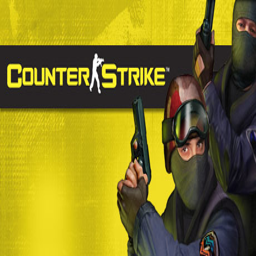

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP1 게임의 ID: 467960, title: Home Behind, Score: 0.9999523162841797
선택된 게임의 content: In Home Behind, you take on the role of a refugee cast out from your homeland by a band of rebels. Your home and the peace you enjoyed has been destroyed, and your family has disappeared. Can you survive the struggle, famine, and sickness to make it to the safety of Europe?
선택된 게임의 genres: ['Adventure', 'RPG', 'Survival', 'Indie', 'Casual', 'Simulation', 'Strategy', 'Singleplayer', 'Building', 'Side Scroller', 'Roguelite', '2D', 'Roguelike', 'Mouse only', 'Replay Value', 'Difficult', 'Third Person', 'Turn-Based Tactics', 'Atmospheric', 'Politics']


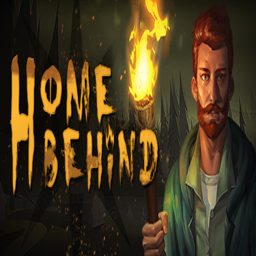

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP2 게임의 ID: 1132070, title: 5.0, Score: 0.9999499320983887
선택된 게임의 content: Sensei challenge you! This is a hardcore arcade game in which you will need to complete level in less than 5 seconds!
선택된 게임의 genres: ['Indie', 'Pixel Graphics', 'Platformer', '2D']


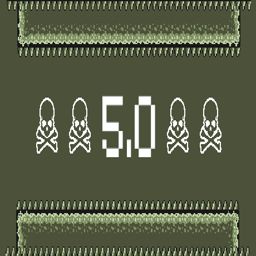

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP3 게임의 ID: 1081470, title: Born of Fire, Score: 0.9999493956565857
선택된 게임의 content: The free trial version of Born of Fire includes the fully integrated Roguelike tower mode, card upgrade system, chest system, and the exciting worldwide 1 vs 1 match mode. Initially, there will be two heroes with different features: Commander and Mage.、
선택된 게임의 genres: ['Roguelike Deckbuilder', 'Free to Play', 'Strategy', 'Early Access', 'RPG', 'Roguelite', 'Card Game', 'PvP', 'Casual', 'Fantasy', 'Indie', 'Multiplayer', 'Singleplayer', 'Adventure', 'Roguelike']


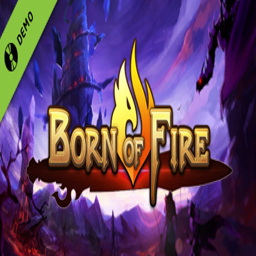

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP4 게임의 ID: 237870, title: Planet Explorers, Score: 0.9999467134475708
선택된 게임의 content: Planet Explorers is an open world sandbox adventure RPG game set on a distant planet. The game uses a new OpenCL calculated voxel system to allow players to change the terrain in any way, create new objects such as weapons, vehicles, objects, and do it anywhere.
선택된 게임의 genres: ['Open World Survival Craft', 'Sandbox', 'Open World', 'Survival', 'Adventure', 'Crafting', 'Multiplayer', 'RPG', 'Exploration', 'Building', 'Sci-fi', 'Indie', 'Action', 'Co-op', 'Simulation', 'Early Access', 'Voxel', 'Singleplayer', 'Third Person', 'Action RPG']


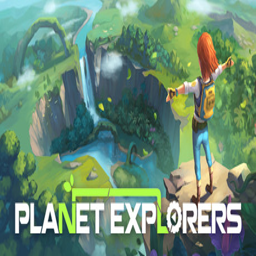

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP5 게임의 ID: 1136240, title: Crowd Control, Score: 0.9999457597732544
선택된 게임의 content: Crowd control is a game about risk & play style exploration.Up to four players spend a minute and a half attempting to make the longest Mexican wave in existence.
선택된 게임의 genres: ['Free to Play', 'Indie', 'Strategy', 'Casual', 'Action', '2D', 'Singleplayer', 'Replay Value', 'Relaxing', 'Pixel Graphics', 'Great Soundtrack', 'Family Friendly', 'Atmospheric', 'Simulation']


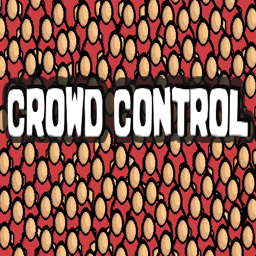

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP6 게임의 ID: 207170, title: Legend of Grimrock, Score: 0.9999452233314514
선택된 게임의 content: Use the Dungeon Editor to build entirely new adventures and challenges for other players to solve.
선택된 게임의 genres: ['Dungeon Crawler', 'RPG', 'Indie', 'Grid-Based Movement', 'Fantasy', 'Old School', 'Adventure', 'Singleplayer', 'Party-Based RPG', 'Puzzle', 'First-Person', 'Real-Time', 'Atmospheric', 'Moddable', 'Retro', 'Difficult', 'Action', 'Character Customization', 'Tactical', 'Level Editor']


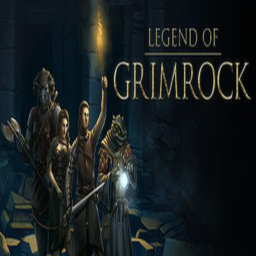

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP7 게임의 ID: 1016250, title: 100$, Score: 0.9999448657035828
선택된 게임의 content: Money rules the world! This is a casual puzzle for all who loves to get his wallet full of cash. Embark on an unforgettable journey to parallel worlds - to regain the most important thing in the modern world - money.
선택된 게임의 genres: ['Indie', 'Puzzle']


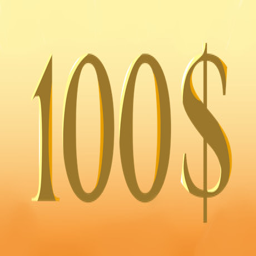

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP8 게임의 ID: 221380, title: Age of Empires II (2013), Score: 0.9999440312385559
선택된 게임의 content: Age of Empires II has been re-imagined in high definition with new features, trading cards, improved AI, workshop support, multiplayer, Steamworks integration and more!
선택된 게임의 genres: ['Strategy', 'RTS', 'Medieval', 'Multiplayer', 'Classic', 'Historical', 'Base Building', 'City Builder', 'Resource Management', 'Singleplayer', 'Tactical', 'Real-Time', 'Co-op', 'Competitive', 'Replay Value', 'Remake', '2D', 'Isometric', 'Action', 'Adventure']


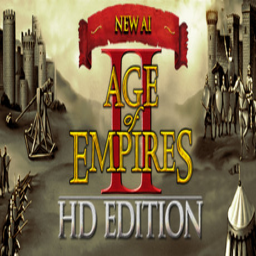

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP9 게임의 ID: 1270930, title: Hentai vs Virus: I Am Waifu, Score: 0.9999436140060425
선택된 게임의 content: The game about anime girl trying to stop the dangerous virus. The Hentai-prequel story of waifus fighting with evil forces
선택된 게임의 genres: ['NSFW', 'Character Customization', 'Mature', 'Nudity', 'Hentai', 'Casual', 'Character Action Game', 'Anime', 'Female Protagonist', 'Sexual Content', 'Cute', 'Zombies', 'Third-Person Shooter', 'Arcade', 'Action', 'Shooter', 'Adventure', 'Memes', 'Singleplayer', 'Violent']


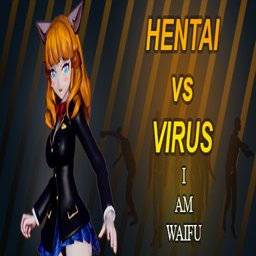

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP10 게임의 ID: 549040, title: Biotope, Score: 0.9999434947967529
선택된 게임의 content: Biotope will be the most detailed and realistic aquarium simulator on the market. Biotope makes it possible to create complex aquarist ecosystems and simulate realistic life cycles of plants and fish.
선택된 게임의 genres: ['Simulation', 'Casual', 'Strategy', 'Early Access']


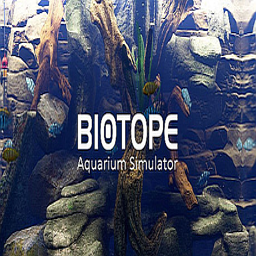

----------------------------------------------------------------------------------------------------


In [23]:
get_sim_game(preds_T, 0)